In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
import pickle

from analysis import PandasAnalysis

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/onelep/output/Run2/*.root")
babies

['../analysis/studies/onelep/output/Run2/TTX.root',
 '../analysis/studies/onelep/output/Run2/TTbar1L.root',
 '../analysis/studies/onelep/output/Run2/TTbar2L.root',
 '../analysis/studies/onelep/output/Run2/VH.root',
 '../analysis/studies/onelep/output/Run2/WJets.root',
 '../analysis/studies/onelep/output/Run2/Bosons.root',
 '../analysis/studies/onelep/output/Run2/VBSWH_mkW.root']

In [3]:
vbswh = PandasAnalysis(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=["xsec_sf"]
)

In [4]:
vbswh.make_selection("M_jj > 1500 and abs(deta_jj) > 5 and ST > 500")
vbswh.set_split_column(ratio=0.75, name="split")

In [5]:
vbswh.df["abs_deta_jj"] = np.abs(vbswh.df.deta_jj)
vbswh.df.columns

Index(['lep_pdgID', 'lep_pt', 'lep_eta', 'lep_phi', 'LT', 'hbbjet_score',
       'hbbjet_pt', 'hbbjet_eta', 'hbbjet_phi', 'hbbjet_mass',
       'hbbjet_msoftdrop', 'xsec_sf', 'event', 'MET', 'ST', 'lep_sf',
       'lep_sf_up', 'lep_sf_dn', 'HT', 'n_jets_pt30', 'n_fatjets',
       'n_loose_b_jets', 'n_medium_b_jets', 'n_tight_b_jets', 'ld_vbs_jet_pt',
       'tr_vbs_jet_pt', 'M_jj', 'deta_jj', 'dR_jj', 'name', 'is_signal',
       'event_weight', 'split', 'split_weight', 'abs_deta_jj'],
      dtype='object')

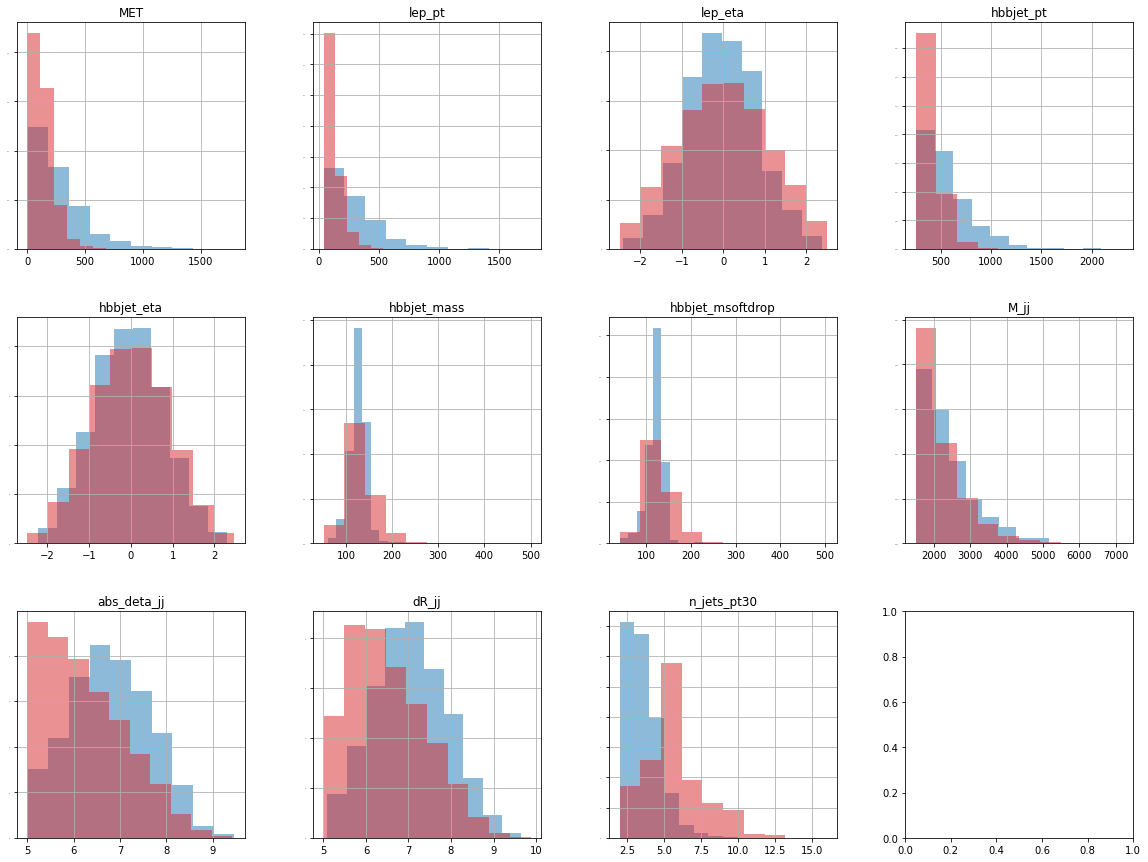

In [6]:
# # Select features
features = [
    "MET",
    "lep_pt",
    "lep_eta",
#     "hbbjet_score",
    "hbbjet_pt",
    "hbbjet_eta",
    "hbbjet_mass",
    "hbbjet_msoftdrop",
    "M_jj",
    "abs_deta_jj",
    "dR_jj",
    "n_jets_pt30"
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(20,15))

sig_df = vbswh.sig_df()
bkg_df = vbswh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [7]:
train_df = vbswh.df[vbswh.df.split].sample(frac=1.)
test_df = vbswh.df[~vbswh.df.split].sample(frac=1.)

# BDT Input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain, "train"), (dtest, "eval")]

# BDT Parameters Setup
params = {}
params["objective"] = "binary:logistic"

# BDT Knobs (Parameters)
num_round = 500                  # Number of training rounds
params["eta"] = 0.1              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 8.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [8]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.91365	eval-auc:0.92325
[1]	train-auc:0.93869	eval-auc:0.94219
[2]	train-auc:0.94252	eval-auc:0.94798
[3]	train-auc:0.94283	eval-auc:0.94960
[4]	train-auc:0.94418	eval-auc:0.95002
[5]	train-auc:0.94457	eval-auc:0.94960
[6]	train-auc:0.94504	eval-auc:0.95061
[7]	train-auc:0.94653	eval-auc:0.95153
[8]	train-auc:0.94838	eval-auc:0.95284
[9]	train-auc:0.94913	eval-auc:0.95371
[10]	train-auc:0.94969	eval-auc:0.95409
[11]	train-auc:0.95028	eval-auc:0.95472
[12]	train-auc:0.95116	eval-auc:0.95555
[13]	train-auc:0.95086	eval-auc:0.95557
[14]	train-auc:0.95385	eval-auc:0.95834
[15]	train-auc:0.95403	eval-auc:0.95905
[16]	train-auc:0.95471	eval-auc:0.95963
[17]	train-auc:0.95587	eval-auc:0.96023
[18]	train-auc:0.95671	eval-auc:0.96086
[19]	train-auc:0.95681	eval-auc:0.96078
[20]	train-auc:0.95713	eval-auc:0.96061
[21]	train-auc:0.95739	eval-auc:0.96094
[22]	train-auc:0.95814	eval-auc:0.96162
[23]	train-auc:0.95900	eval-auc:0.96261
[24]	train-auc:0.95948	eval-auc:0.96297
[25]	train

In [9]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


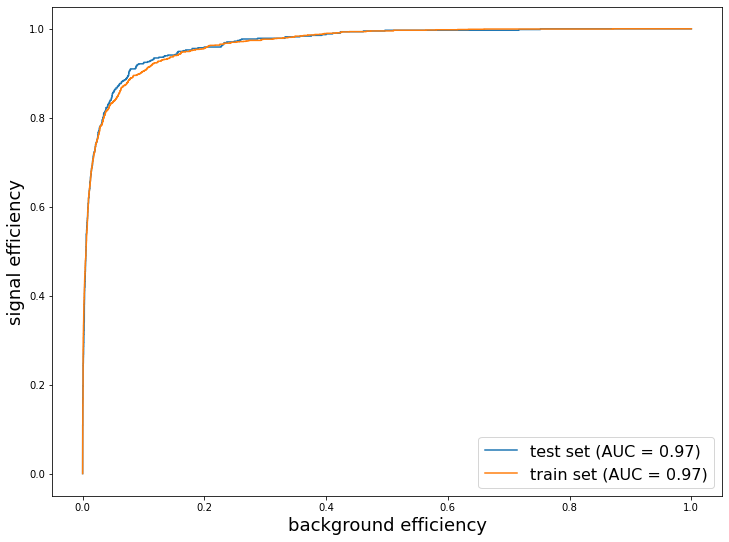

In [10]:
fig, axes = plt.subplots(figsize=(12,9))

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency", size=18);
plt.ylabel("signal efficiency", size=18);
plt.legend(fontsize=16);

In [11]:
vbswh.df["bdt"] = bst.predict(xgb.DMatrix(vbswh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:xlabel='BDT Score', ylabel='Events'>

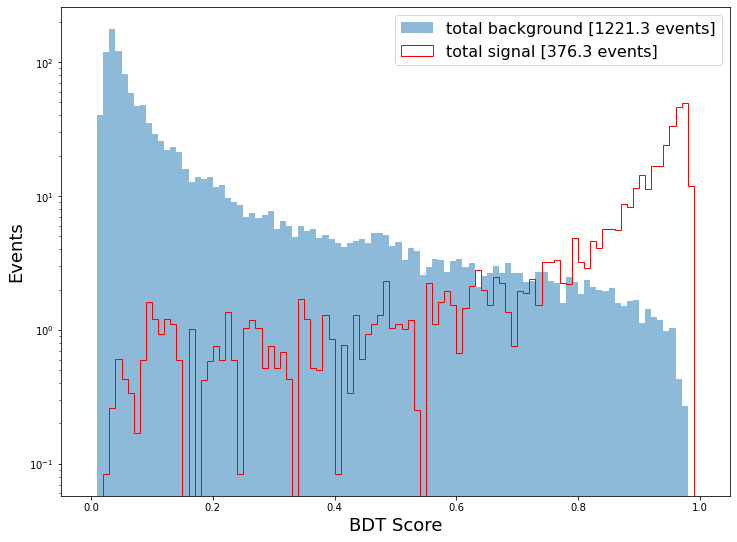

In [12]:
vbswh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 101), xlabel="BDT Score", logy=True)

In [22]:
vbswh.fom_scan("bdt", [0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.962,0.97,0.98])

sel,sig,bkg,fom
bdt > 0.8,283.50005780160427,26.419008063142655,55.15627116635354
bdt > 0.9,223.4725690856576,7.724028682490143,80.40855967454908
bdt > 0.91,209.07054705917835,6.5888435046447285,81.44946938553267
bdt > 0.92,197.83096912503242,5.1507238947463065,87.16861456059948
bdt > 0.93,181.2049462273717,3.9037179337549333,91.71298594675253
bdt > 0.94,164.56905791908503,2.7276507995932207,99.64460684336989
bdt > 0.95,140.62309584766626,1.7392121035857144,106.63023841173509
bdt > 0.96,107.21018901467323,0.6994767382905138,128.1886056430254
bdt > 0.962,97.2872624322772,0.4705850146274315,141.81982210830506
bdt > 0.97,61.21793944388628,0.2722229709470412,117.33195924901527
bdt > 0.98,11.874470062553883,0.0,inf


/home/users/jguiang/projects/vbs/notebooks/analysis.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  base_selection="", fom=lambda s, b: s/np.sqrt(b)):


In [14]:
vbswh.fom_scan("hbbjet_score", [0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98], base_selection="bdt > 0.96")

sel,sig,bkg,fom
bdt > 0.96 and hbbjet_score > 0.91,106.45299434661865,0.6986483752455115,127.35868176654074
bdt > 0.96 and hbbjet_score > 0.92,105.42885955423117,0.7410649141431804,122.47046948387626
bdt > 0.96 and hbbjet_score > 0.93,104.14680927246809,0.662303983583115,127.972686025208
bdt > 0.96 and hbbjet_score > 0.94,102.28647463023663,0.6181555049261078,130.09761651652929
bdt > 0.96 and hbbjet_score > 0.95,100.92541916668415,0.5694510260364041,133.74340380445972
bdt > 0.96 and hbbjet_score > 0.96,99.47432398796082,0.5679036668152548,131.99991757477528
bdt > 0.96 and hbbjet_score > 0.97,96.07837171852589,0.48410719708772376,138.08765823294902
bdt > 0.96 and hbbjet_score > 0.98,90.98678155988455,0.4375949669338297,137.54415641459357


In [15]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.1
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,8.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,3.3546016216278076


<AxesSubplot:ylabel='Events'>

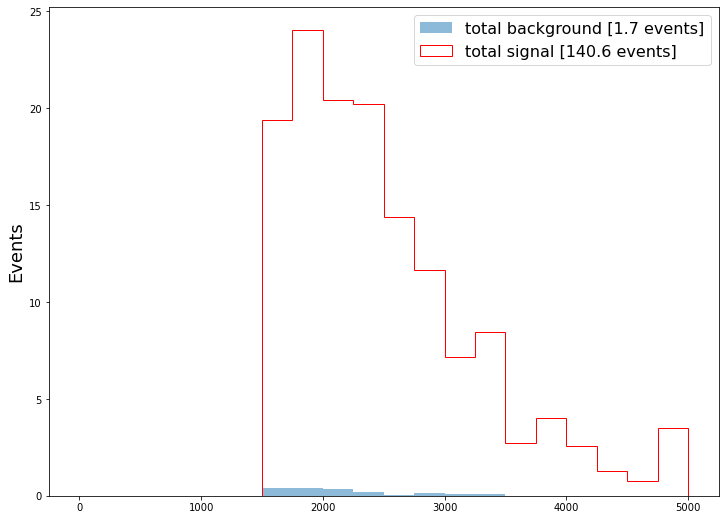

In [16]:
vbswh.plot_sig_vs_bkg("M_jj", np.linspace(0, 5000, 21), selection="bdt > 0.95")

<AxesSubplot:ylabel='Events'>

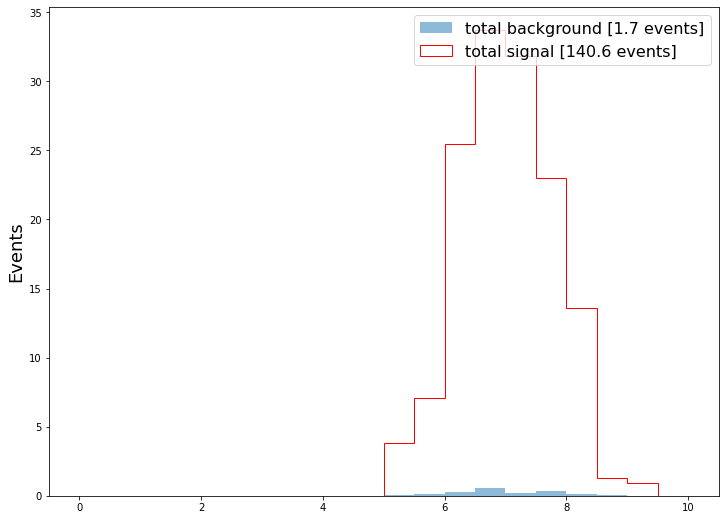

In [17]:
vbswh.plot_sig_vs_bkg("deta_jj", np.linspace(0, 10, 21), selection="bdt > 0.95", abs=True)

<AxesSubplot:ylabel='Events'>

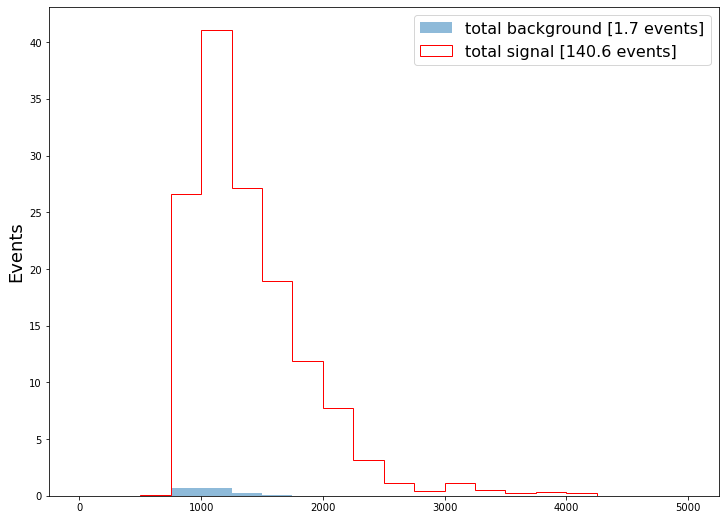

In [18]:
vbswh.plot_sig_vs_bkg("ST", np.linspace(0, 5000, 21), selection="bdt > 0.95")

In [19]:
vbswh.fom_scan("ST", [800, 900, 1000, 1100, 1200, 1300, 1400, 1500], base_selection="bdt > 0.95")

sel,sig,bkg,fom
bdt > 0.95 and ST > 800,139.26755765080452,1.6635359976692143,107.97764663914585
bdt > 0.95 and ST > 900,129.92726357281208,1.4061010996131245,109.57008986417993
bdt > 0.95 and ST > 1000,113.94755805283785,1.0186275136559289,112.90087849446677
bdt > 0.95 and ST > 1100,94.12604983150959,0.6699945543271042,114.9937394017258
bdt > 0.95 and ST > 1200,79.46728143841028,0.4936009551893221,113.1098328001999
bdt > 0.95 and ST > 1300,67.94427394866943,0.2860253257822478,127.04296402341501
bdt > 0.95 and ST > 1400,56.543506629765034,0.12549126987869386,159.61583764425905
bdt > 0.95 and ST > 1500,45.74660010635853,0.07317298908310477,169.1155041868431


In [20]:
# Write features list
with open("../analysis/studies/onelep/bdt_features.txt", "w") as txt_file:
    txt_file.write("\n".join(features))

# Write BDT model
pickle.dump(bst, open("../analysis/studies/onelep/bdt.pkl", "wb"))
bst.save_model("../analysis/studies/onelep/bdt.model")
bst.dump_model("../analysis/studies/onelep/bdt.json", "../analysis/studies/onelep/bdt_features.txt")